# Summary of avg velocity per run - process all runs

This notebooks takes output from ```ADV_data_01_process_vXX.ipynb``` and ```ADV_data_02_all_profiles_vXX.ipynb``` and performs analysis on the profile data. 

Needs:
- a file called ```summary_coniditions_locations.csv``` to provide spatial information for the 
- a file called ```summary_velocity_mean.csv``` which is the natural output from ```ADV_data_01...```
- a file called ```summary_profile_anal_all.csv``` which is the natural output from ```ADV_data_02...```

User input:
- Data folder
- Profile $x$ location

Version/Change log:
- V01: 

## Loads

In [1]:
# %pylab inline
import numpy as np
from numpy import log, sin, cos, exp, tan, pi
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display, uncomment while working

# uncomment the two lines below when exporting to a pdf
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png','pdf')

#returns the clear-water density in kg/m^3 as a function of temperature [in deg C] and salinity [ppt]
def rho_cw(T,S): 
    rho_fresh=1000*(1-(T +288.9414)/(508929.2*(T+68.12963))*(T-3.9863)**2)
    Acoef = 0.824493 - 0.0040899*T + 0.000076438*T**2 -0.00000082467*T**3 + 0.0000000053675*T**4
    Bcoef = -0.005724 + 0.00010227*T - 0.0000016546*T**2
    return rho_fresh + Acoef*S + Bcoef*S**(3/2) + 0.00048314*S**2 

# returns the clear water kinimatic viscosity in [m^2/s] as a function of temperature [in deg C].
def visc(T):
    return 2.7488e-07+1.4907e-06*exp(-0.034812*T)

## User input

In [2]:
datadir = 'Leviathan_ADV/' # path to the data

profilex = 5.12 # x location in meters where the velocity profile is located

T = 10 # water temperature in deg C

## Find and load the data

In [3]:
veldatafile = 'summary_velocity_mean.csv'
conditionlocationfile = 'summary_coniditions_locations.csv'
profiledata = 'summary_profile_anal_all.csv'

fig_folder = 'Figures'
# Make the output folder
if os.path.isdir(fig_folder) != 1:
    os.mkdir(fig_folder)

data = pd.read_csv(datadir+veldatafile) # reads in the data
info = pd.read_csv(datadir+conditionlocationfile) # reads in the data
profiles = pd.read_csv(datadir+profiledata)

# add columns to info dataframe 
info.insert(loc=1,column='Run',value=info.File.str[0:5])
info.insert(loc=2,column='Point',value=info.File.str[6:8].astype(int))
info.insert(loc=4,column='S',value=info.S_p/100)

runs = info.Run.unique()
# display(data)
# display(info)
# display(profiles)

## Process all of the data

looks for profiles, calculates the depth average and then combines it with the rest of the velocity data for that run

/var/folders/yf/55_zp9dx2gj9bgp5dy24l3_w0000gn/T/ipykernel_90552/2067264147.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


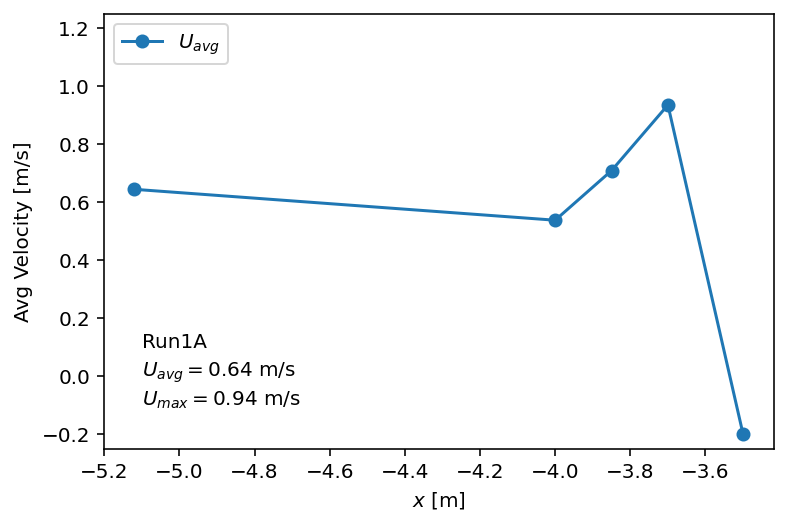

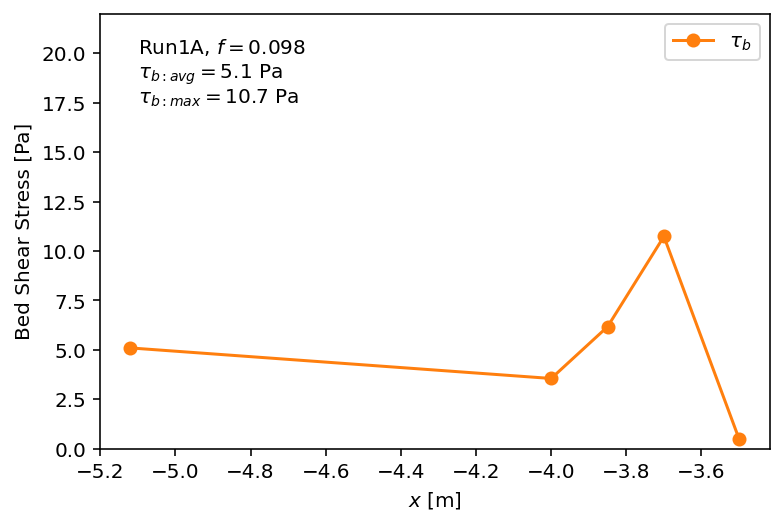

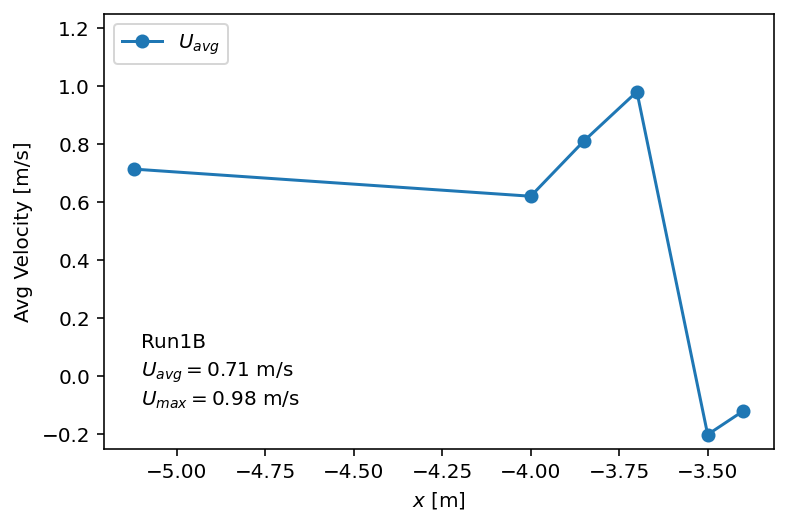

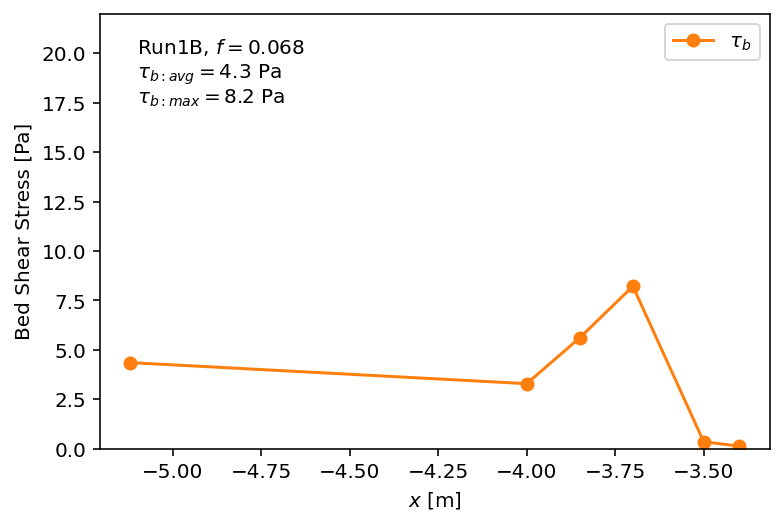

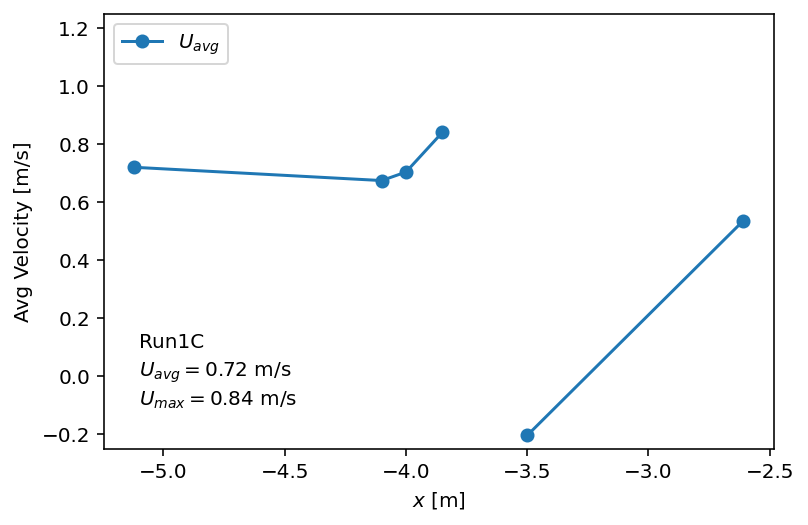

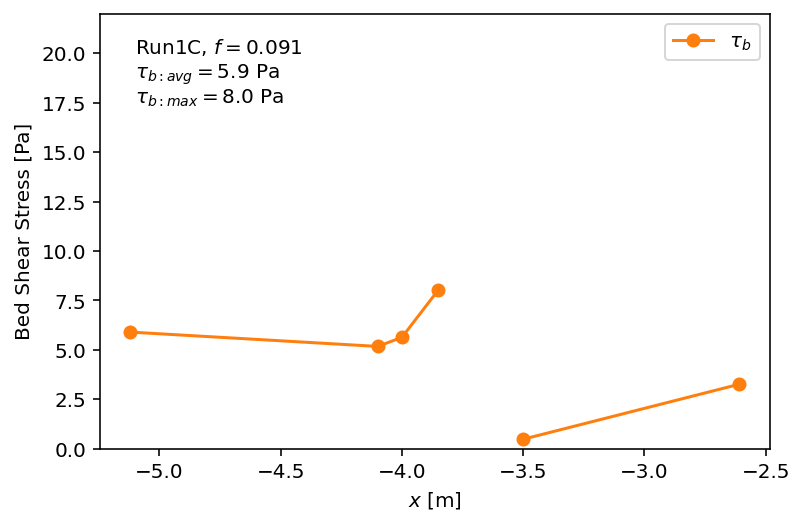

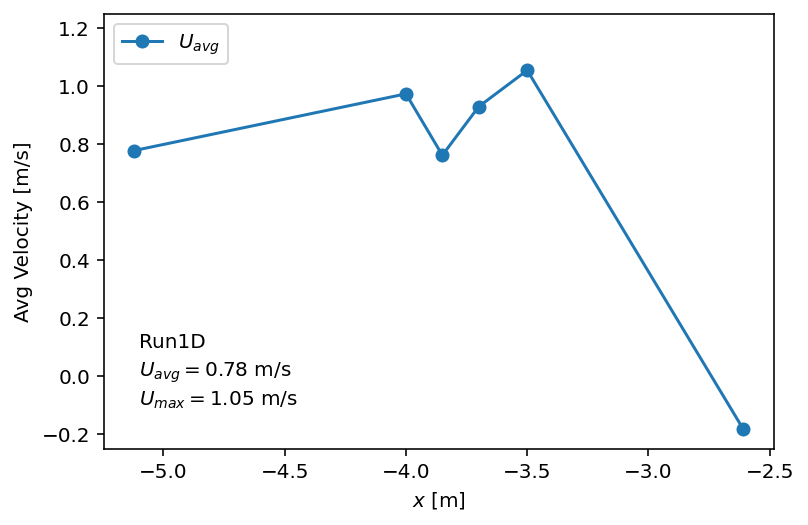

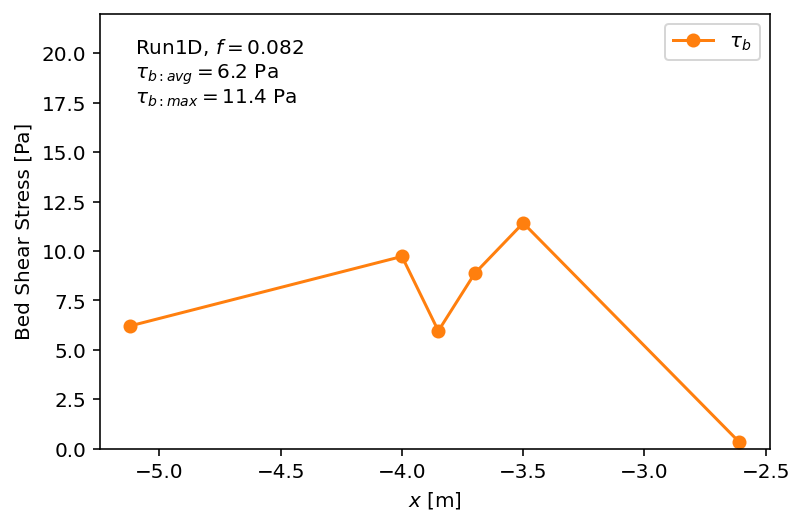

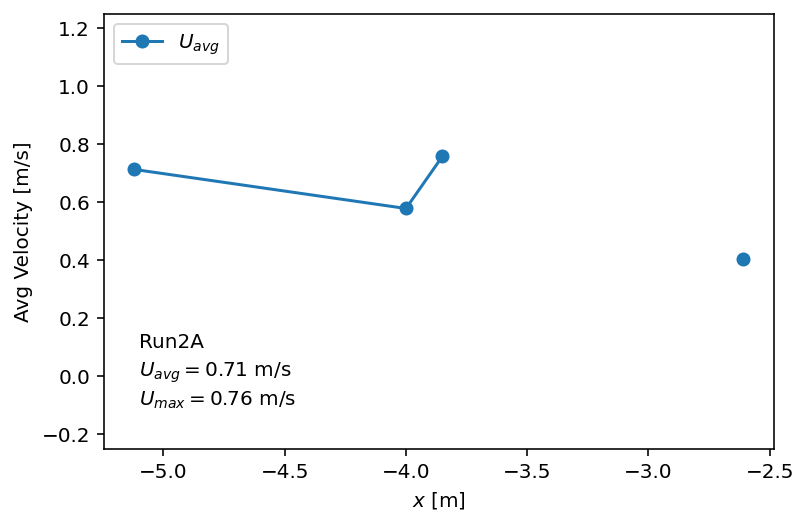

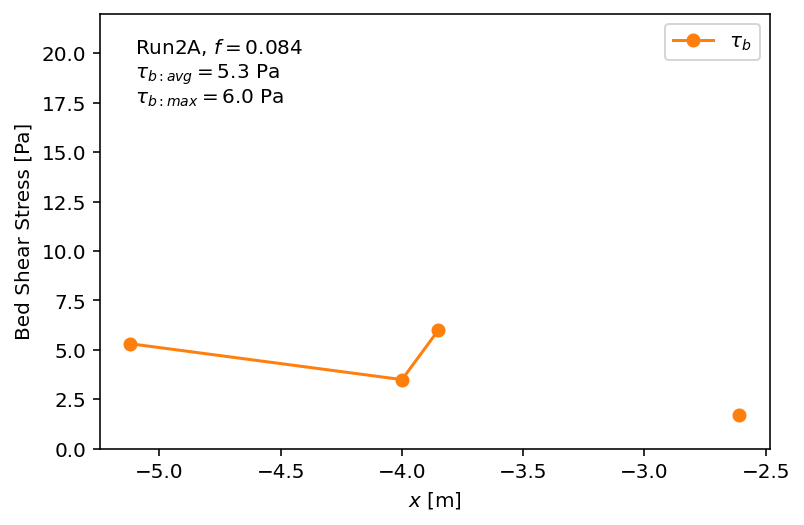

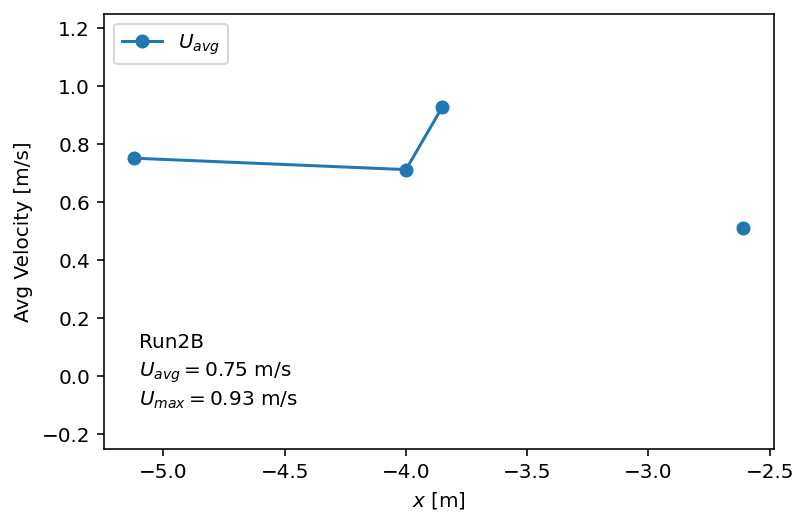

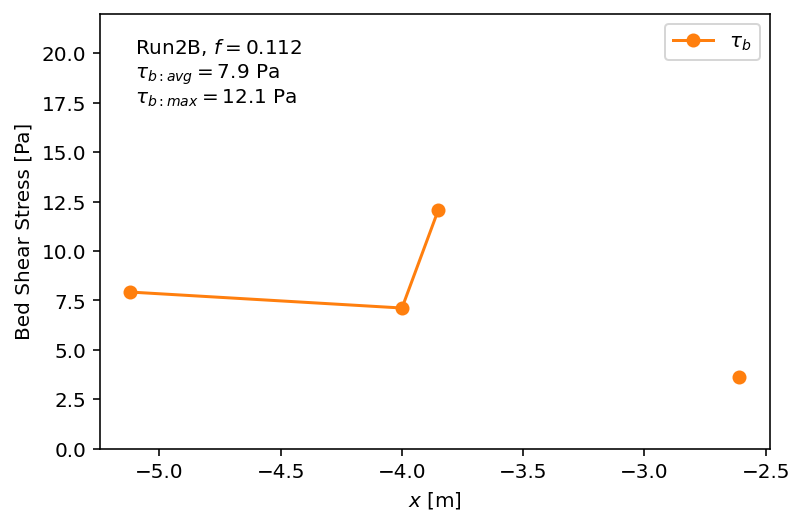

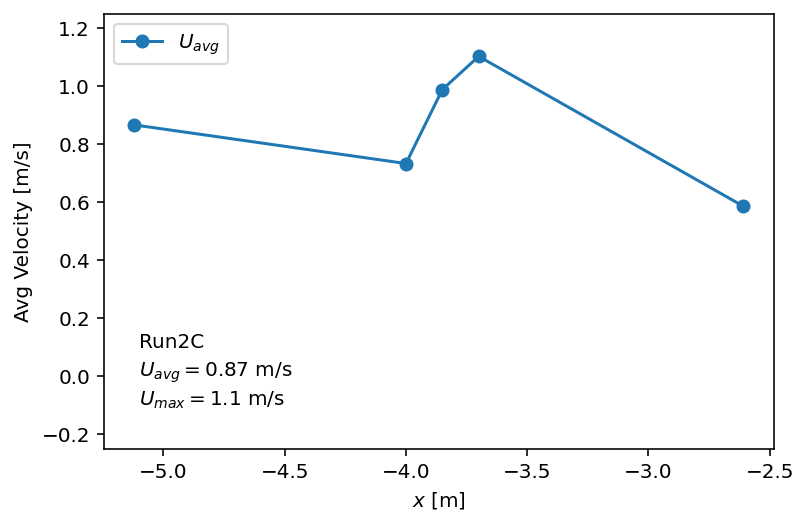

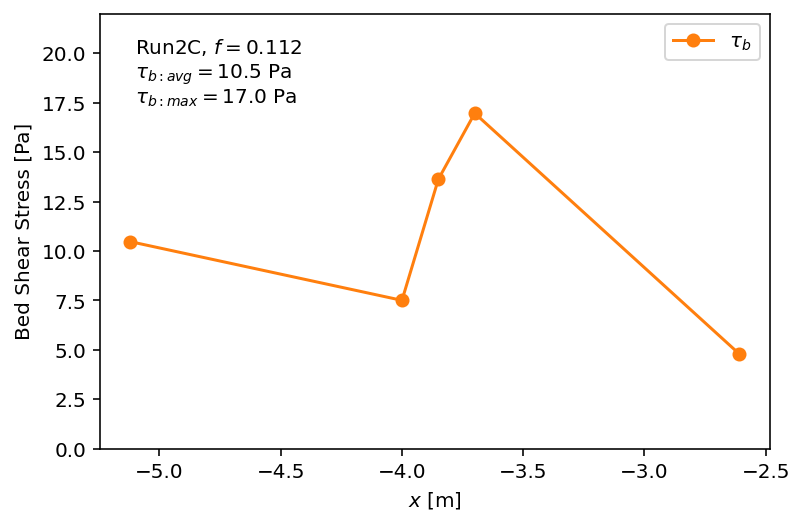

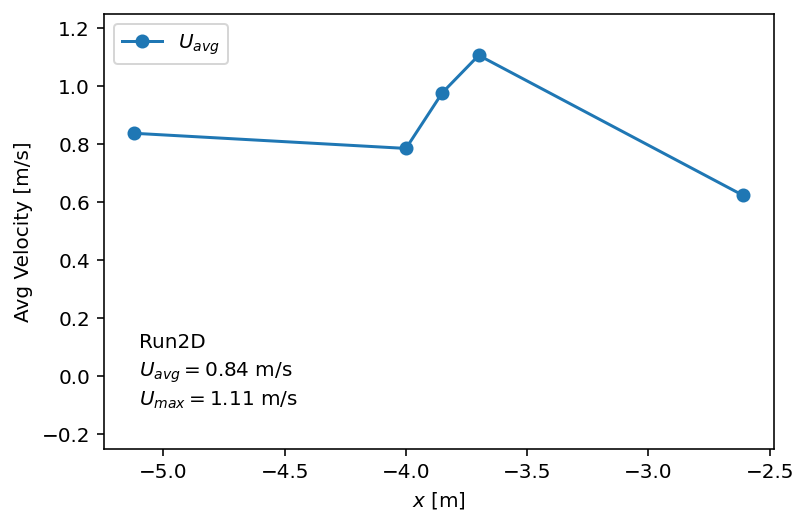

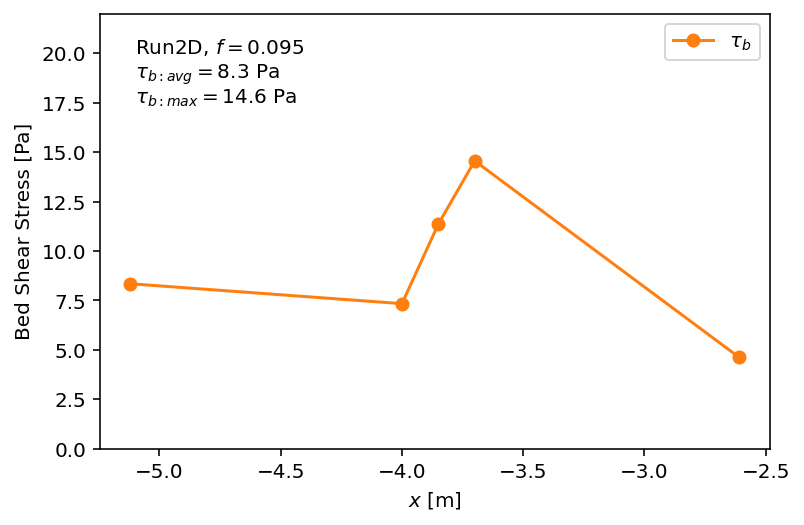

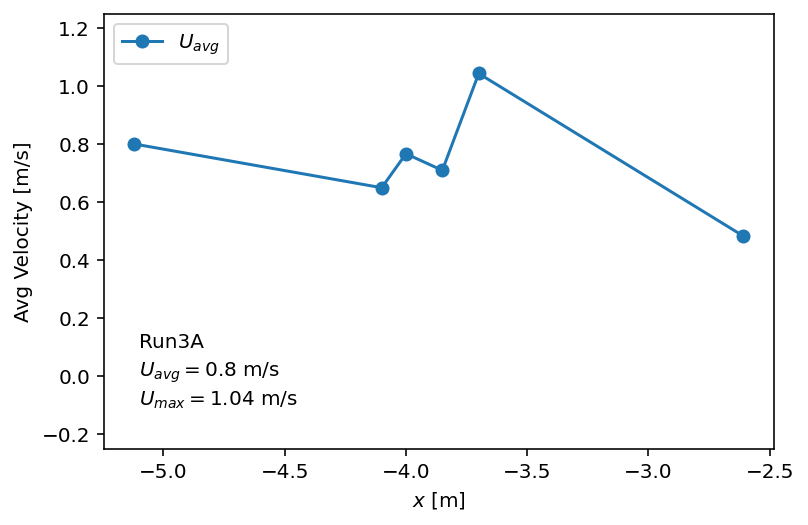

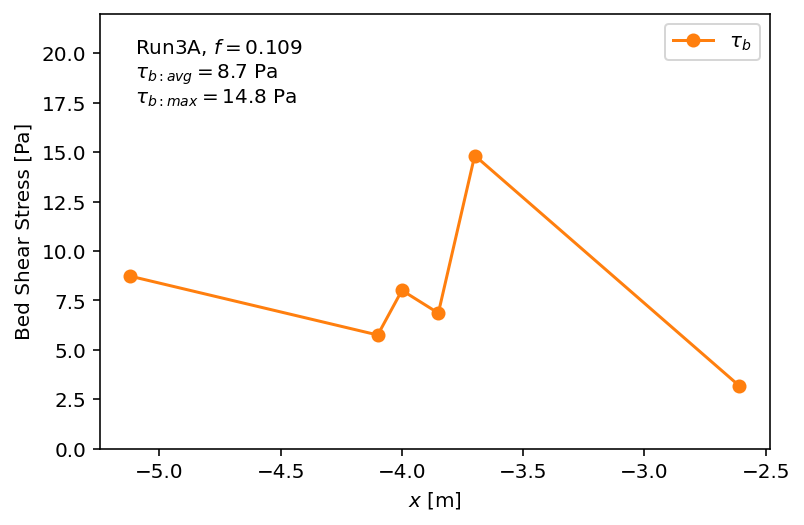

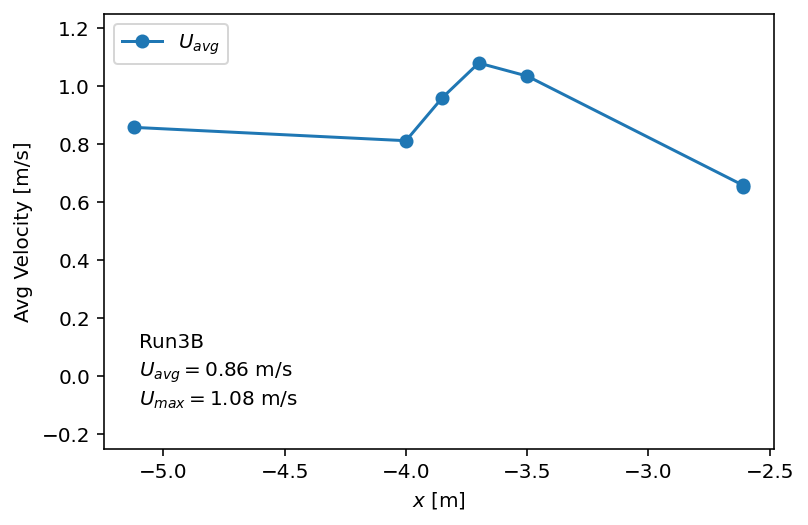

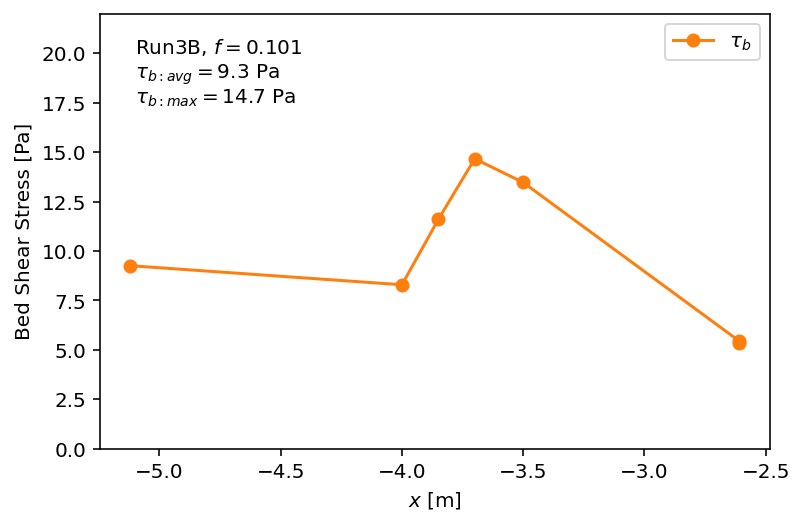

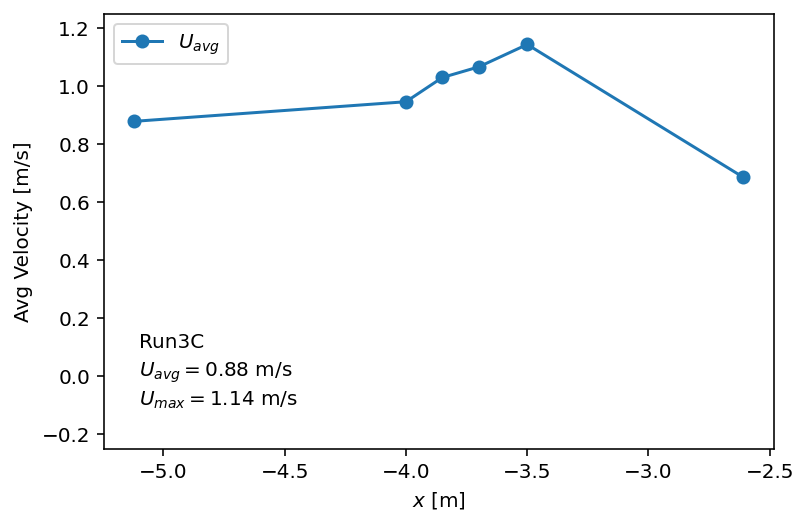

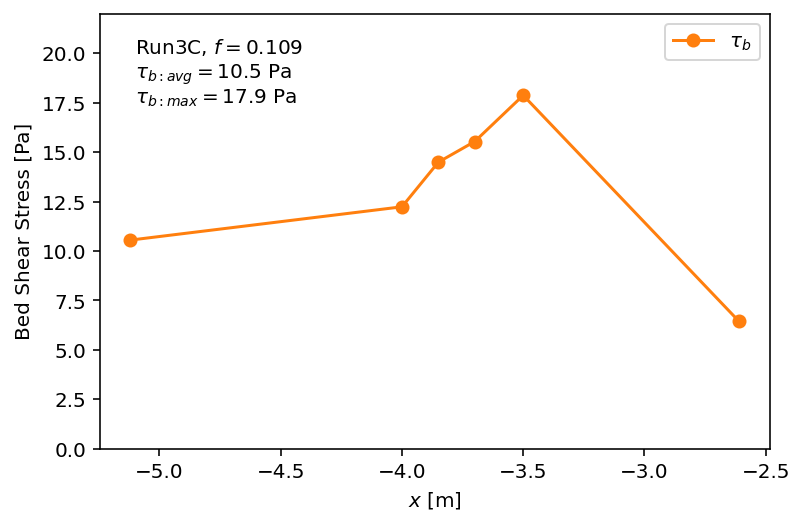

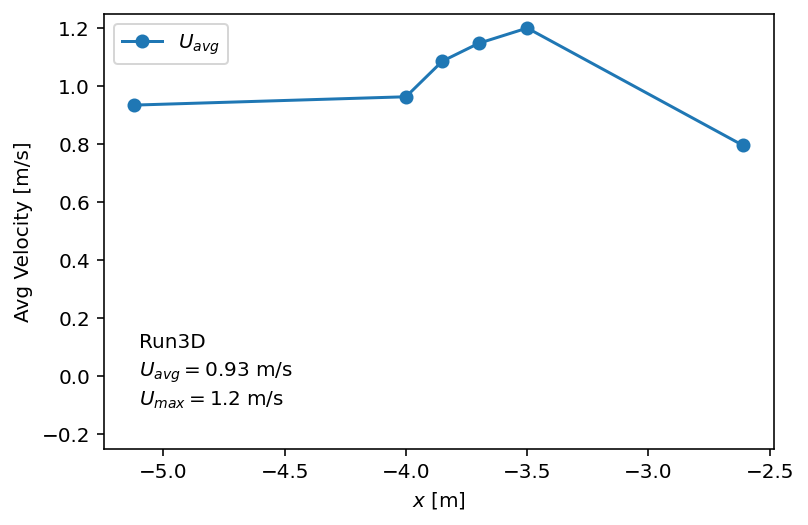

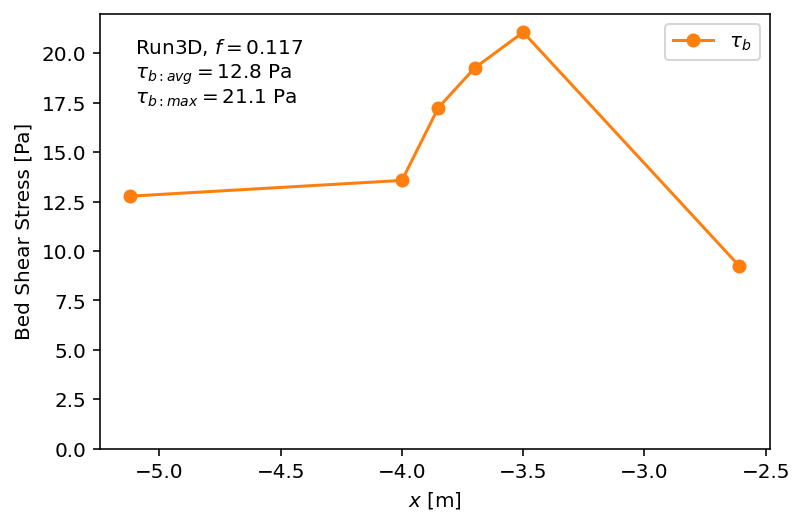

In [4]:
for j in range(0,len(runs)):
    
    run = runs[j]

    rho = rho_cw(T,0)
    output_path=datadir+'/summary_vel_x_'+run+'.csv'

    # pull the profile data ------------------

    profile_summary = profiles[(profiles.Run == run)]
    profile_summary = profile_summary.loc[:, :'uavg_m_s']
    profile_summary['S_p']=profile_summary.S*100
    profile_summary['File']='depth avg'
    profile_summary['Point']='DepthAvg'
    
    Uavg = profile_summary.uavg_m_s.iloc[0]
    f=profiles[(profiles.Run == run)].f_uw.iloc[0]

    # pull the non profile data ------

    npinfo = info[(info.Run == run)&(info.x_m != profilex)].copy() # pull out the non profile for the run
    npinfo = npinfo.sort_values(by=['Point']).reset_index(drop=True) # sort the data on the points in case something is out of order

    npfirst = npinfo.Point.min() # define which points are part of the profile - the first
    nplast = npinfo.Point.max()  # define which points are part of the profile - the last
    npdata = data[(data.Run == run)&(data.Point >= npfirst)&(data.Point <= nplast)].copy() # pull out the profile for the run
    npdata = npdata.sort_values(by=['Point']).reset_index(drop=True)   # sort the data on the points in case something is out of order

    # drop data in the combine... 
    npinfo = npinfo.drop(columns=['Run','Point'])
    npdata = npdata.drop(columns=['snr1','snr2','snr3','snr4','cor1','cor2','cor3','cor4'])
    npdata = npdata.drop(columns=['uu_bar','uv_bar','uw_bar','vv_bar','vw_bar','ww_bar'])
    npdata = npdata.drop(columns=['vavg_m_s','wavg_m_s'])

    summary = pd.concat([npinfo,npdata], axis=1)
    summary = pd.concat((summary, profile_summary), axis = 0)
    summary = summary.sort_values(by=['x_m']).reset_index(drop=True)

    summary['Fr_local']=summary.uavg_m_s/np.sqrt(9.81*summary.h_cm/100)
    summary['tau_b_Pa'] = (f/8)*rho*summary.uavg_m_s**2

    summary.to_csv(output_path, index=False)
    # display(summary)

    UAVGstr = str(np.around(Uavg, decimals=2))
    Umax = str(np.around(summary.uavg_m_s.max(), decimals=2))

    taub_ambient = str(np.around((f/8)*rho*profile_summary.uavg_m_s.iloc[0]**2,decimals=1))
    taub_max = str(np.around(max(summary.tau_b_Pa),decimals=1))
    fric = str(np.around(f,decimals=3))

    # print('Depth average vel, Uavg [m/s] = '+UAVGstr)
    # print('Max vel over nest, Unest [m/s] ='+Umax)
    # print('Unest - Uavg [m/s] =', np.around(summary.uavg_m_s.max()-Uavg , decimals=2))

    fig, ax = plt.subplots()
    ax.plot(-summary.x_m,summary.uavg_m_s, 'o-', alpha=1, label='$U_{avg}$')
    ax.set_xlabel('$x$ [m]')
    ax.set_ylabel('Avg Velocity [m/s]')
    ax.set_ylim(-0.25,1.25)
    ax.text(-5.1,-0.0, '$U_{avg} = $'+UAVGstr+' m/s', backgroundcolor='none', 
            clip_on='True', multialignment='center', alpha=1) #weight = 'bold', 
    ax.text(-5.1,-0.1, '$U_{max} = $'+Umax+' m/s', backgroundcolor='none', 
            clip_on='True', multialignment='center', alpha=1) #weight = 'bold', 
    ax.text(-5.1,0.1, run, backgroundcolor='none', clip_on='True', multialignment='center', alpha=1) #weight = 'bold', 
    plt.legend(loc=2, ncol=1)
    plt.savefig(fig_folder+'/'+run+'_U(x).pdf',bbox_inches="tight", pad_inches=0.005)

    fig, ax = plt.subplots()
    ax.plot(-summary.x_m,summary.tau_b_Pa, 'o-', color='C1', alpha=1, label=r'$\tau_{b}$')
    ax.set_xlabel('$x$ [m]')
    ax.set_ylabel('Bed Shear Stress [Pa]')
    ax.set_ylim(0,22)
    ax.set_ylim(bottom=0)
    ax.text(-5.1,20, run+', $f=$'+fric, backgroundcolor='none', clip_on='True', multialignment='center', alpha=1) #weight = 'bold', 
    ax.text(-5.1,18.75, r'$\tau_{b:avg} = $'+taub_ambient+' Pa', backgroundcolor='none', 
            clip_on='True', multialignment='center', alpha=1) #weight = 'bold', 
    ax.text(-5.1,17.5, r'$\tau_{b:max} = $'+taub_max+' Pa', backgroundcolor='none', 
            clip_on='True', multialignment='center', alpha=1) #weight = 'bold', 
    plt.legend(loc=1, ncol=1)
    plt.savefig(fig_folder+'/'+run+'_tau(x).pdf',bbox_inches="tight", pad_inches=0.005)